In [1]:
import numpy as np
import scipy.io as sio
import h5py
import tensorflow as tf
import pickle
import os
from matplotlib import pyplot as plt
import importlib
import inspect
from copy import deepcopy
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# root directory
if os.getcwd().find('/Users/svnh2') != -1:
    root_directory = '/Users/svnh2/Desktop/projects'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/mindhive/nklab3') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
else:
    raise NameError('No root directory found')
    
# external repositories that depend on the root directory
# reload, in case they've changed
import sys
sys.path.append(root_directory)
from general_analysis import misc

In [2]:


    

# analysis parameters
F_params = {}
F_params['time_win_sec'] = 2
F_params['rank'] = None
F_params['weight_scale'] = 1e-6
F_params['learning_rate'] = 0.0001
F_params['early_stopping_steps'] = 10
F_params['train_val_test_frac'] = [0.6, 0.2, 0.2]
F_params['eval_interval'] = 5
F_params['max_iter'] = 100
F_params['act'] = 'relu'
F_params['seed'] = 0

# directory save results
prediction_directory = misc.mkdir(comp_directory + '/predictions')

# witin the above splits, create training/validation for early stopping
train_val_test = misc.partition_within_labels(C['assignments'], F_params['train_val_test_frac'], seed=1)

j = 1

# load features
X = load_features.load_feats(
    all_features[j], 25, shifts=shifts, demean_feats=demean_feats, std_feats=std_feats, 
    nPCs=nPCs, max_n_features=max_n_features, overwrite=False)
F = X['F']

# directroy with results for this feature
feature_directory = prediction_directory + '/' + X['feature_format_string']

# create single layer CNN with above parameters
importlib.reload(cnn)
layer = {}
layer['type'] = 'conv'
layer['n_kern'] = 1
layer['time_win_sec'] = F_params['time_win_sec']
layer['act'] = F_params['act']
layer['rank'] = F_params['rank']
layers = []
layers.append(layer)
n_tps = 75
sr = 25
data_dims = [n_stimuli, n_tps, 1]
n_feats = F.shape[2]

i = 12
    
stat_file = [feature_directory '/comp' + str(i) + '.p']

if os.path.exists(stat_file):
    
    S = pickle.load(open(formatted_file, "rb"))
    
else:
    
    # select a signle component
    R_onecomp = np.reshape(R[:,:75,i], [n_stimuli, n_tps, 1])

    # build the TF graph
    tf.reset_default_graph()
    net = cnn.Net(data_dims, n_feats, sr, deepcopy(layers), loss_type='squared_error',
                  weight_scale=F_params['weight_scale']/F.shape[2], seed=F_params['seed'], 
                  log_dir=feature_directory, log_id='comp13')
    net.build()

    # train the graph
    net.train(F, R_onecomp, max_iter=F_params['max_iter'],
              eval_interval=F_params['eval_interval'], learning_rate=F_params['learning_rate'], 
              train_val_test=train_val_test, early_stopping_steps=F_params['early_stopping_steps'], print_iter=True)

SyntaxError: invalid syntax (<ipython-input-2-cf4cc38076d6>, line 52)

Import CNN code, reset the graph

In [2]:
import cnn
importlib.reload(cnn)
tf.reset_default_graph()

In [27]:
tf.random_normal

<function tensorflow.python.ops.random_ops.random_normal>

Create some random features for input to CNN

In [3]:
# features
n_feats = 20
n_stim = 300
n_tps_per_stim = 100
feat_dims = [n_stim, n_tps_per_stim, n_feats]
sr_Hz = 100
F = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])

Create a random 2-layer network and sample from it

In [36]:
layers = []

# convolutional layer
layer = {}
layer['type'] = 'conv'
layer['time_win_sec'] = 0.1
layer['act'] = 'relu'
layer['n_kern'] = 2
layer['rank'] = 1
layers.append(layer)

# # normalization layer
# layer = {}
# layer['type'] = 'normalization'
# layer['time_win_sec'] = 0.1
# layer['act'] = 'identity'
# layer['n_kern'] = 1
# layer['rank'] = 10
# layers.append(layer)

# pooling/reweighting layer
layer = {}
layer['type'] = 'conv'
layer['time_win_sec'] = 0.1
layer['act'] = 'identity'
layer['n_kern'] = 20
layer['rank'] = None
layers.append(layer)

# create network
net1_seed = 2
n_resp = 20
data_dims = [n_stim, n_tps_per_stim, n_resp]
tf.reset_default_graph()
net1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed)
net1.build()
D = net1.predict(F)

In [20]:
n_feats
# n_feats
sr_Hz

100

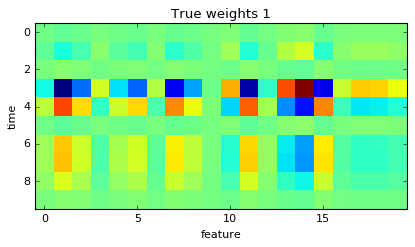

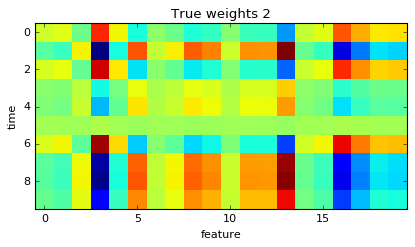

In [37]:
# True STRFs
net1_layer_vals = net1.layer_vals()
plt.imshow(net1_layer_vals[0]['W'][:,:,0], interpolation='none')
plt.ylabel('time'); plt.xlabel('feature')
plt.title('True weights 1')
plt.show()
plt.imshow(net1_layer_vals[0]['W'][:,:,1], interpolation='none')
plt.ylabel('time'); plt.xlabel('feature')
plt.title('True weights 2')
plt.show()

Create a second network, and try to fit to the data from the first

In [38]:
# initialize second network
net2_seed = net1_seed+1
net2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed, weight_scale=0.001)
net2.build()

# train
n_train = np.int32(np.round(n_stim*0.6))
n_val = np.int32(np.round(n_stim*0.2))
n_test = n_stim - n_train - n_val
train_val_test = np.concatenate((np.zeros(n_train), np.ones(n_val), np.ones(n_test)*2), 0)
early_stopping_steps = 5 # 0 implies no early stopping
net2.train(F, D, max_iter=1000, eval_interval=30, learning_rate=0.01, 
           batch_size=10, train_val_test=train_val_test, 
           early_stopping_steps=early_stopping_steps)

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
INFO:tensorflow:Restoring parameters from /Users/svnh2/Desktop/projects/scratch/seed3-model.ckpt


Plots illustrating results

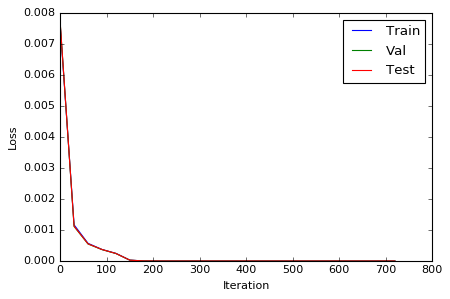

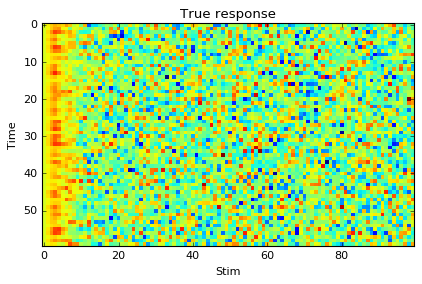

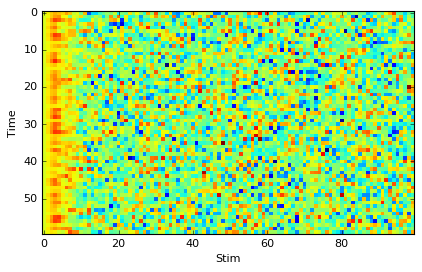

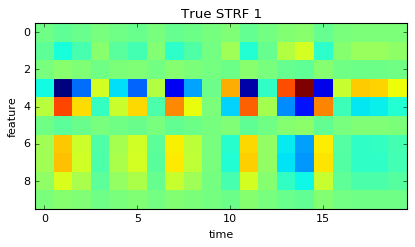

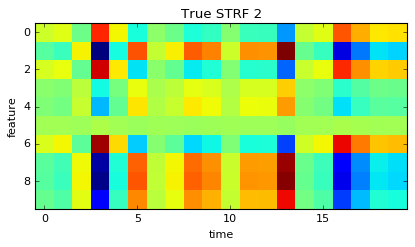

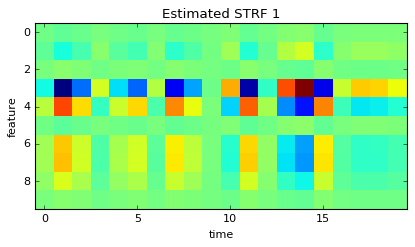

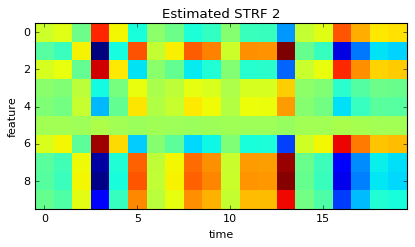

In [39]:
# loss
start_iter = 0
plt.plot(net2.iteration[start_iter:], net2.train_loss[start_iter:])
plt.plot(net2.iteration[start_iter:], net2.val_loss[start_iter:])
plt.plot(net2.iteration[start_iter:], net2.test_loss[start_iter:])
plt.legend(['Train', 'Val', 'Test'], loc='upper right')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.show()

# true and estimated response (first response)
D_test = net1.predict(F[train_val_test==2,
                        :,:])
plt.imshow(D_test[:,:,0], interpolation='none')
plt.title('True response')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show()
D_test_estimated = net2.predict(F[train_val_test==2,:,:])
plt.imshow(D_test_estimated[:,:,0], interpolation='none')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show('Estimated response')
plt.show()

# true and estimated STRFs (layer 1)
net1_layer_vals = net1.layer_vals()
net2_layer_vals = net2.layer_vals()
plt.imshow(net1_layer_vals[0]['W'][:,:,0], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('True STRF 1')
plt.show()
plt.imshow(net1_layer_vals[0]['W'][:,:,1], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('True STRF 2')
plt.show()
plt.imshow(net2_layer_vals[0]['W'][:,:,0], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('Estimated STRF 1')
plt.show()
plt.imshow(net2_layer_vals[0]['W'][:,:,1], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('Estimated STRF 2')
plt.show()

# # true and estimated pooling weights
# plt.plot(net1_layer_vals[1]['W'][0,:,:].transpose())
# plt.title('True Weights')
# plt.show()
# plt.plot(net2_layer_vals[1]['W'][0,:,:].transpose())
# plt.title('Estimated Weights')
# plt.show()

Same as above, but with two features and two networks trained with different weights. Useful when you want to predict responses from two different feature sets. 

In [14]:
# two sets of features
F1 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])
F2 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])

# create features and data
net1_seed = 0
net1_1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed)
net1_2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed+1) 
multi_net1 = cnn.MultiNet([net1_1, net1_2])
multi_net1.build()
D = multi_net1.predict([F1, F2])

# new multi net
net2_seed = net1_seed + 10
net2_1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed, weight_scale=0.001)
net2_2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed+1, weight_scale=0.001)
multi_net2 = cnn.MultiNet([net2_1, net2_2])
multi_net2.build()

# train
n_train = np.int32(np.round(n_stim*0.6))
n_val = np.int32(np.round(n_stim*0.2))
n_test = n_stim - n_train - n_val
train_val_test = np.concatenate((np.zeros(n_train), np.ones(n_val), np.ones(n_test)*2), 0)
early_stopping_steps = 0 # 0 implies no early stopping
multi_net2.train([F1, F2], D, max_iter=1000, eval_interval=30, learning_rate=0.01, 
           batch_size=10, train_val_test=train_val_test, 
           early_stopping_steps=early_stopping_steps)

# loss
start_iter = 0
plt.plot(multi_net2.iteration[start_iter:], multi_net2.train_loss[start_iter:])
plt.plot(multi_net2.iteration[start_iter:], multi_net2.val_loss[start_iter:])
plt.plot(multi_net2.iteration[start_iter:], multi_net2.test_loss[start_iter:])
plt.legend(['Train', 'Val', 'Test'], loc='upper right')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.show()

# true and estimated response (first response)
F_test = [F1[train_val_test==2,:,:], F2[train_val_test==2,:,:]]
D_test = multi_net1.predict(F_test)
plt.imshow(D_test[:,:,0], interpolation='none')
plt.title('True response')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show()
D_test_estimated = multi_net2.predict(F_test)
plt.imshow(D_test_estimated[:,:,0], interpolation='none')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show('Estimated response')
plt.show()

# true and estimated weights (first layer)
for i in range(2):
    multi_net1_layer_vals = multi_net1.layer_vals()
    multi_net2_layer_vals = multi_net2.layer_vals()
    plt.imshow(multi_net1_layer_vals[i][0]['W'][:,:,0], interpolation='none')
    plt.xlabel('time'); plt.ylabel('feature')
    plt.title('True weights (Subnet ' + str(i) + ')')
    plt.show()
    plt.imshow(multi_net2_layer_vals[i][0]['W'][:,:,0], interpolation='none')
    plt.xlabel('time'); plt.ylabel('feature')
    plt.title('True weights (Subnet ' + str(i) + ')')
    plt.show()

AttributeError: 'MultiNet' object has no attribute 'error'

In [8]:
tf.pad?